## Mini Project: Option Pricing
### 1. DP algorithm
Consider the simplest binary tree process of the stock price:
$$
s _ { t + 1 } = \left\{ \begin{array} { l l } { ( 1 + r ) s _ { t } } & { \text { with probability } p } \\ { s _ { t } / ( 1 + r ) } & { \text { with probability } 1 - p } \end{array} \right.
$$

Value of an American Put: 
0.17134658245153428


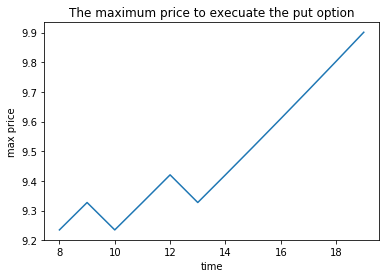

In [3]:
import matplotlib.pyplot as plt
from typing import Tuple
import numpy as np

def AmericanPut(T: int, p:float, r: float, X: float, s0: float) -> Tuple[float, np.array]:
    price_mat = np.zeros((T+1, T+1))
    for i in np.arange(T+1):
        price_mat[:(i+1), i] = (1 + r)**(-i + 2*np.arange(i+1))
    price_mat = price_mat*s0
    cashflow_mat = X - price_mat
    cashflow_mat = cashflow_mat*(cashflow_mat > 0)
    
    val_mat = cashflow_mat.copy()
    action_mat = np.zeros(val_mat.shape)
    for i in reversed(np.arange(T)):
        tmp1 = val_mat[:(i+2),i+1].copy()
        tmp0 = val_mat[:(i+1),i].copy()
        tmp3 = (1 - p)*tmp1[:-1] + p*tmp1[1:]
        tmp = np.concatenate((tmp3.reshape(len(tmp3),1), tmp0.reshape(len(tmp0),1)),1 )
        action_mat[:(i+1),i] = np.apply_along_axis(np.argmax, 1, tmp)
        val_mat[:(i+1),i] = np.apply_along_axis(max, 1, tmp)
    
    max_price_seq = np.zeros(T+1)
    max_price_loc = sum(action_mat) - 1
    for i in np.arange(T+1):
        if max_price_loc[i] == -1:
            max_price_seq[i] = -1
        else:
            max_price_seq[i] = price_mat[int(max_price_loc[i]),i]
            
    return val_mat[0,0], max_price_seq

put, max_price_seq = AmericanPut(20, 0.5, 0.01, 10, 10)
print('Value of an American Put: ')
print(put)
start = len(max_price_seq[:-1][max_price_seq[:-1]==-1])
end = 19
x_axis = np.linspace(start, end, end - start +1)
price = max_price_seq[max_price_seq>0]
plt.plot(x_axis, price)
plt.title('The maximum price to execuate the put option')
plt.ylabel('max price')
plt.xlabel('time')
plt.show()

### 2. Policy Iteration and Value Iteration

In [9]:
from src.mdp_refined import MDPRefined

def cashflow(x):
    if x >= 0:
        return x
    else:
        return 0

# Generate mdp
T = 20
r = 0.01
p0 = 10.0
x = 10.0
prob = 0.5
state = [((1.0+r)**(2.0*i-t)*p0,t) for t in range(1, T+1) for i in range(t+1)]
inf = {s: {1: {'Terminal': (1.0, x - s[0])}, 0: {(round(s[0]*(1+r),10), s[1]+1): (prob, 0.0), \
         (round(s[0]/(1.0+r),10), s[1]+1): (1.0-prob,0.0)} } if s[1] <= T-1 else \
     {1: {'Terminal': (1.0, cashflow(x - s[0]))}} for s in state}
state = [(round(s[0],10),s[1]) for s in state]
inf = {(round(s[0],10), s[1]): v for s,v in inf.items()}
state.append('Terminal')
inf['Terminal'] = {1: {'Terminal': (1.0, 0.0)}, 0: {'Terminal': (1.0, 0.0)}}

gamma = 1
mdp = MDPRefined(inf,gamma)
# Generate policy data
policy_data = {s: {1: 0.6, 0: 0.4} if s[0] < 10 else {0: 0.6, 1: 0.4} for s in mdp.nt_states_list if s[1]<T}
policy_data['Terminal'] = {1: 0.5, 0: 0.5}
for s in state:
    if s[1] == T:
        policy_data[s] = {1: 1.0}

pol_opt, val_opt = mdp.policy_iteration(policy_data)
val_list = [(k, v) for k,v in val_opt.items()]
print('Value of an American Put by policy iteration: ')
print((val_list[0][1]+ val_list[1][1])/2)
pol_opt, val_opt = mdp.value_iteration()
print('Value of an American Put by value iteration: ')
print((val_list[0][1]+ val_list[1][1])/2)

Number of iterations: 9.
Value of an American Put by policy iteration: 
0.17134658245153428
Number of iterations: 20.
Value of an American Put by value iteration: 
0.17134658245153428


### 3. RL model free control

In [18]:
from src.td0_control import TD0_control

gamma_val = 0.9
mdp_ref_obj1 = MDPRefined(inf, gamma_val)
mdp_rep_obj = mdp_ref_obj1.get_mdp_rep_for_rl_tabular()
epsilon_val = 0.1
epsilon_half_life_val = 100
learning_rate_val = 0.1
learning_rate_decay_val = 1e6
episodes_limit = 5000
max_steps_val = 1000

sarsa = TD0_control(
        mdp_rep_obj,
        epsilon_val,
        epsilon_half_life_val,
        learning_rate_val,
        learning_rate_decay_val,
        episodes_limit,
        max_steps_val,
        'Sarsa'
    )
print("Value-action function estimates with Sarsa")
qv_sarsa = sarsa.get_qv_func_dict()
qv_list = [v for k,v in qv_sarsa.items()]
print((qv_list[0][1] + qv_list[0][0])/2)

Value-action function estimates with Sarsa
0.04076241927927919


In [19]:
qlearning = TD0_control(
        mdp_rep_obj,
        epsilon_val,
        epsilon_half_life_val,
        learning_rate_val,
        learning_rate_decay_val,
        episodes_limit,
        max_steps_val,
        'Q-learning'
    )

print("Value-action function estimates with Q-learning")
qv_qlearn = qlearning.get_qv_func_dict()
qv_list = [v for k,v in qv_qlearn.items()]
print((qv_list[0][1] + qv_list[0][0])/2)

Value-action function estimates with Q-learning
0.03428812384264077
